In [12]:
# Imports
# Gymnasium imports
import gymnasium as gym 
from gymnasium import Env
from gymnasium.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

# Import helpers
import numpy as np
import pandas as pd
import random
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from pathlib import Path

from collections import deque

# Import stable baselines
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_checker import check_env

from Environment.env_v6 import *
from Functions.visualization_functions import *

In [2]:
# Configuration of the network
with open('./Config/network_config_v0.json') as file:
    network_config = file.read()

EP_LENGTH = 52 # Length of the episode

Node Attributes:
Node A: {'type': 'manufacturer', 'I': 30}
Node B: {'type': 'manufacturer', 'I': 28}
Node C: {'type': 'manufacturer', 'I': 32}
Node D: {'type': 'distributor'}
Node S: {'type': 'source'}


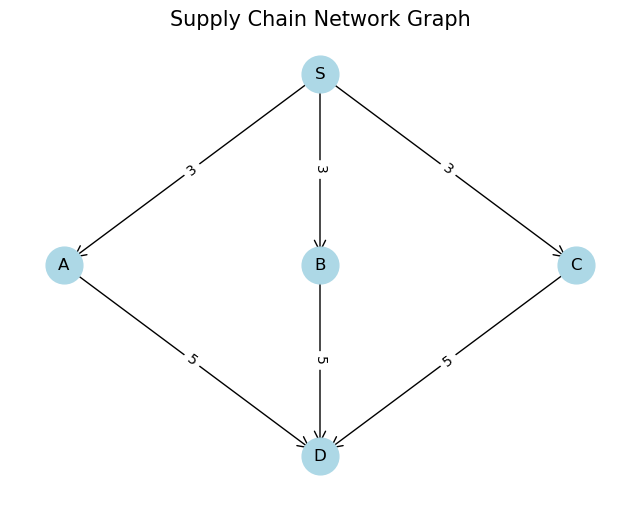

In [3]:
env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human",
                   model_type="A2C")

check_env(env, warn=True)

env.render_network()

In [5]:
log_path = os.path.join('Training', 'Logs', 'A2C')

model_path = os.path.join('Training', 'Models', 'A2C')

In [6]:
def make_env():
    # Create a new environment here
    env = SS_Mngmt_Env(network_config=network_config, EP_LENGTH=EP_LENGTH, render_mode="human", model_type="A2C")
    return env

In [7]:
# Define ranges of hyperparameters to test
hyperparams_grid = {
    "learning_rate": [0.0001, 0.0003, 0.0005],
    "gamma": [0.95, 0.99],
    "num_envs": [4, 8]
}

# Generate all combinations of hyperparameters
hyperparams_combinations = list(product(*hyperparams_grid.values()))
hyperparams_names = list(hyperparams_grid.keys())

In [8]:
def train_and_evaluate(params, log_path=log_path, model_path=model_path, num_episodes=500_000):
    # Unpack hyperparameters
    learning_rate, gamma, num_envs = params
    
    # Define environment
    vec_env = make_vec_env(make_env, n_envs=num_envs)
    
    # Initialize the model with specified hyperparameters
    model = A2C("MlpPolicy", vec_env, learning_rate=learning_rate, gamma=gamma,
                verbose=0, tensorboard_log=log_path)
    
    # Train the model
    model.learn(total_timesteps=num_episodes)
    
    # Save model
    model_save_path = f"{model_path}/A2C_lr{learning_rate}_gamma{gamma}_envs{num_envs}.zip"
    model.save(model_save_path)
    
    # Evaluate the model
    mean_reward, std_reward = evaluate_policy(model, vec_env, n_eval_episodes=10, render=False)
    
    return mean_reward, std_reward, model_save_path

In [9]:
# Prepare a DataFrame to store results
results = []

for i, params in enumerate(hyperparams_combinations):
    print(
        f"Running experiment {i+1}/{len(hyperparams_combinations)} with params: {params}"
    )
    mean_reward, std_reward, model_path = train_and_evaluate(params)

    # Record the results
    result = dict(zip(hyperparams_names, params))
    result["mean_reward"] = mean_reward
    result["std_reward"] = std_reward
    result["model_path"] = model_path
    results.append(result)

# Convert results to a DataFrame for easy comparison
results_df = pd.DataFrame(results)
results_df.to_csv("./Training/A2C_hyperparameter_search_results.csv", index=False)

# Display the top-performing configurations
print(results_df.sort_values(by="mean_reward", ascending=False).head())

Running experiment 1/12 with params: (0.0001, 0.95, 4)
Using cpu device
Logging to Training/Logs/A2C_1
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 52        |
|    ep_rew_mean        | -1.99e+04 |
| time/                 |           |
|    fps                | 4012      |
|    iterations         | 100       |
|    time_elapsed       | 0         |
|    total_timesteps    | 2000      |
| train/                |           |
|    entropy_loss       | -3.29     |
|    explained_variance | -0.000893 |
|    learning_rate      | 0.0001    |
|    n_updates          | 99        |
|    policy_loss        | -3.03e+03 |
|    value_loss         | 1.11e+06  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 52        |
|    ep_rew_mean        | -1.92e+04 |
| time/                 |           |
|    fps                | 4383      |
|    iterations        

/Users/jonasrenfer/miniconda3/envs/rl-scm/lib/python3.12/site-packages/stable_baselines3/common/save_util.py:284: UserWarning: Path 'Training/Models/A2C' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 52        |
|    ep_rew_mean        | -1.98e+04 |
| time/                 |           |
|    fps                | 5102      |
|    iterations         | 100       |
|    time_elapsed       | 0         |
|    total_timesteps    | 4000      |
| train/                |           |
|    entropy_loss       | -3.29     |
|    explained_variance | 0.000519  |
|    learning_rate      | 0.0001    |
|    n_updates          | 99        |
|    policy_loss        | -3.97e+03 |
|    value_loss         | 1.88e+06  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 52        |
|    ep_rew_mean        | -2.01e+04 |
| time/                 |           |
|    fps                | 6062      |
|    iterations         | 200       |
|    time_elapsed       | 1         |
|    total_timesteps    | 8000      |
| train/    

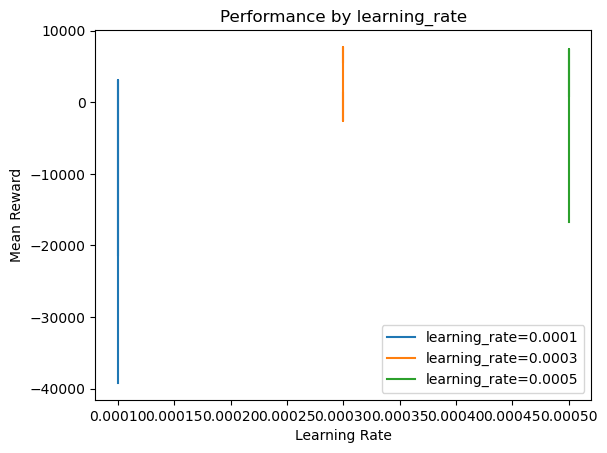

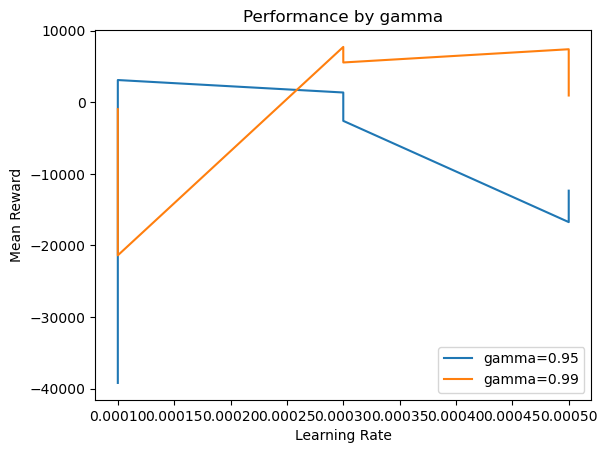

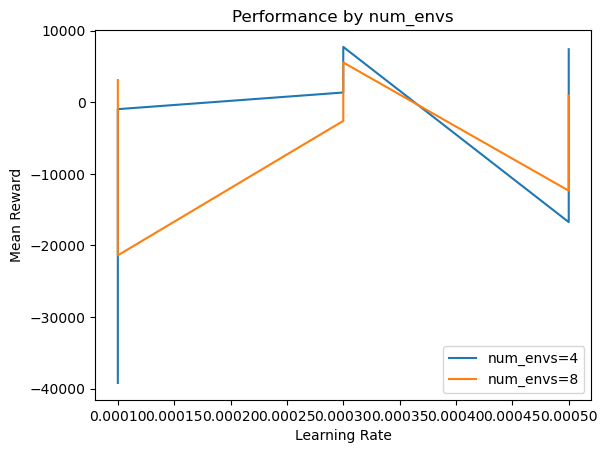

In [10]:
for param in hyperparams_names:
    plt.figure()
    for value in hyperparams_grid[param]:
        subset = results_df[results_df[param] == value]
        plt.plot(subset["learning_rate"], subset["mean_reward"], label=f"{param}={value}")
    plt.xlabel("Learning Rate")
    plt.ylabel("Mean Reward")
    plt.title(f"Performance by {param}")
    plt.legend()
    plt.show()

In [13]:
# Configuration Parameters
EP_LENGTH = 52
NUM_ENVS = 4
MODEL_DIR = Path("Training/Models/A2C")
MODEL_NAME = "A2C_lr0.0003_gamma0.99_envs4.zip"
MODEL_PATH = MODEL_DIR / MODEL_NAME


def make_env():
    """Create and return a new instance of SS_Mngmt_Env."""
    return SS_Mngmt_Env(
        network_config=network_config, EP_LENGTH=EP_LENGTH, render_mode="human", model_type="A2C"
    )


# Set up vectorized environment
vec_env = make_vec_env(make_env, n_envs=NUM_ENVS)

# Load pre-trained model
if MODEL_PATH.is_file():
    model = A2C.load(MODEL_PATH, env=vec_env)
    print("Model loaded successfully.")
else:
    raise FileNotFoundError(
        f"Model file not found at {MODEL_PATH}. Ensure the model is trained and saved in the specified location."
    )

Model loaded successfully.


In [14]:
evaluate_policy(model, vec_env, n_eval_episodes=10, render=True, return_episode_rewards=True)

Episode Length: 1
Stock Level: [[30. 20. 32.]]
Planned Demand: [0. 8. 0.]
Actual Demand: [0. 8. 0.]
Action: [15, 15, 15]
Order: [0 0 0]
Reward: 0

Backlog:
{'A': deque([]), 'B': deque([]), 'C': deque([])}
Order Queue:
{   'A': deque([0, 0, 15], maxlen=3),
    'B': deque([0, 0, 15], maxlen=3),
    'C': deque([0, 0, 15], maxlen=3)}

Episode Length: 1
Stock Level: [[24. 23. 24.]]
Planned Demand: [ 5.  9. 10.]
Actual Demand: [6. 5. 8.]
Action: [15, 15, 15]
Order: [0 0 0]
Reward: 0

Backlog:
{'A': deque([]), 'B': deque([]), 'C': deque([])}
Order Queue:
{   'A': deque([0, 0, 15], maxlen=3),
    'B': deque([0, 0, 15], maxlen=3),
    'C': deque([0, 0, 15], maxlen=3)}

Episode Length: 1
Stock Level: [[22. 28. 32.]]
Planned Demand: [12.  0.  0.]
Actual Demand: [8. 0. 0.]
Action: [15, 15, 15]
Order: [0 0 0]
Reward: 0

Backlog:
{'A': deque([]), 'B': deque([]), 'C': deque([])}
Order Queue:
{   'A': deque([0, 0, 15], maxlen=3),
    'B': deque([0, 0, 15], maxlen=3),
    'C': deque([0, 0, 15], maxlen=

([8698.0,
  928.0,
  8361.5,
  7452.5,
  6158.5,
  9033.0,
  8319.5,
  7668.5,
  8324.0,
  5008.0],
 [52, 52, 52, 52, 52, 52, 52, 52, 52, 52])

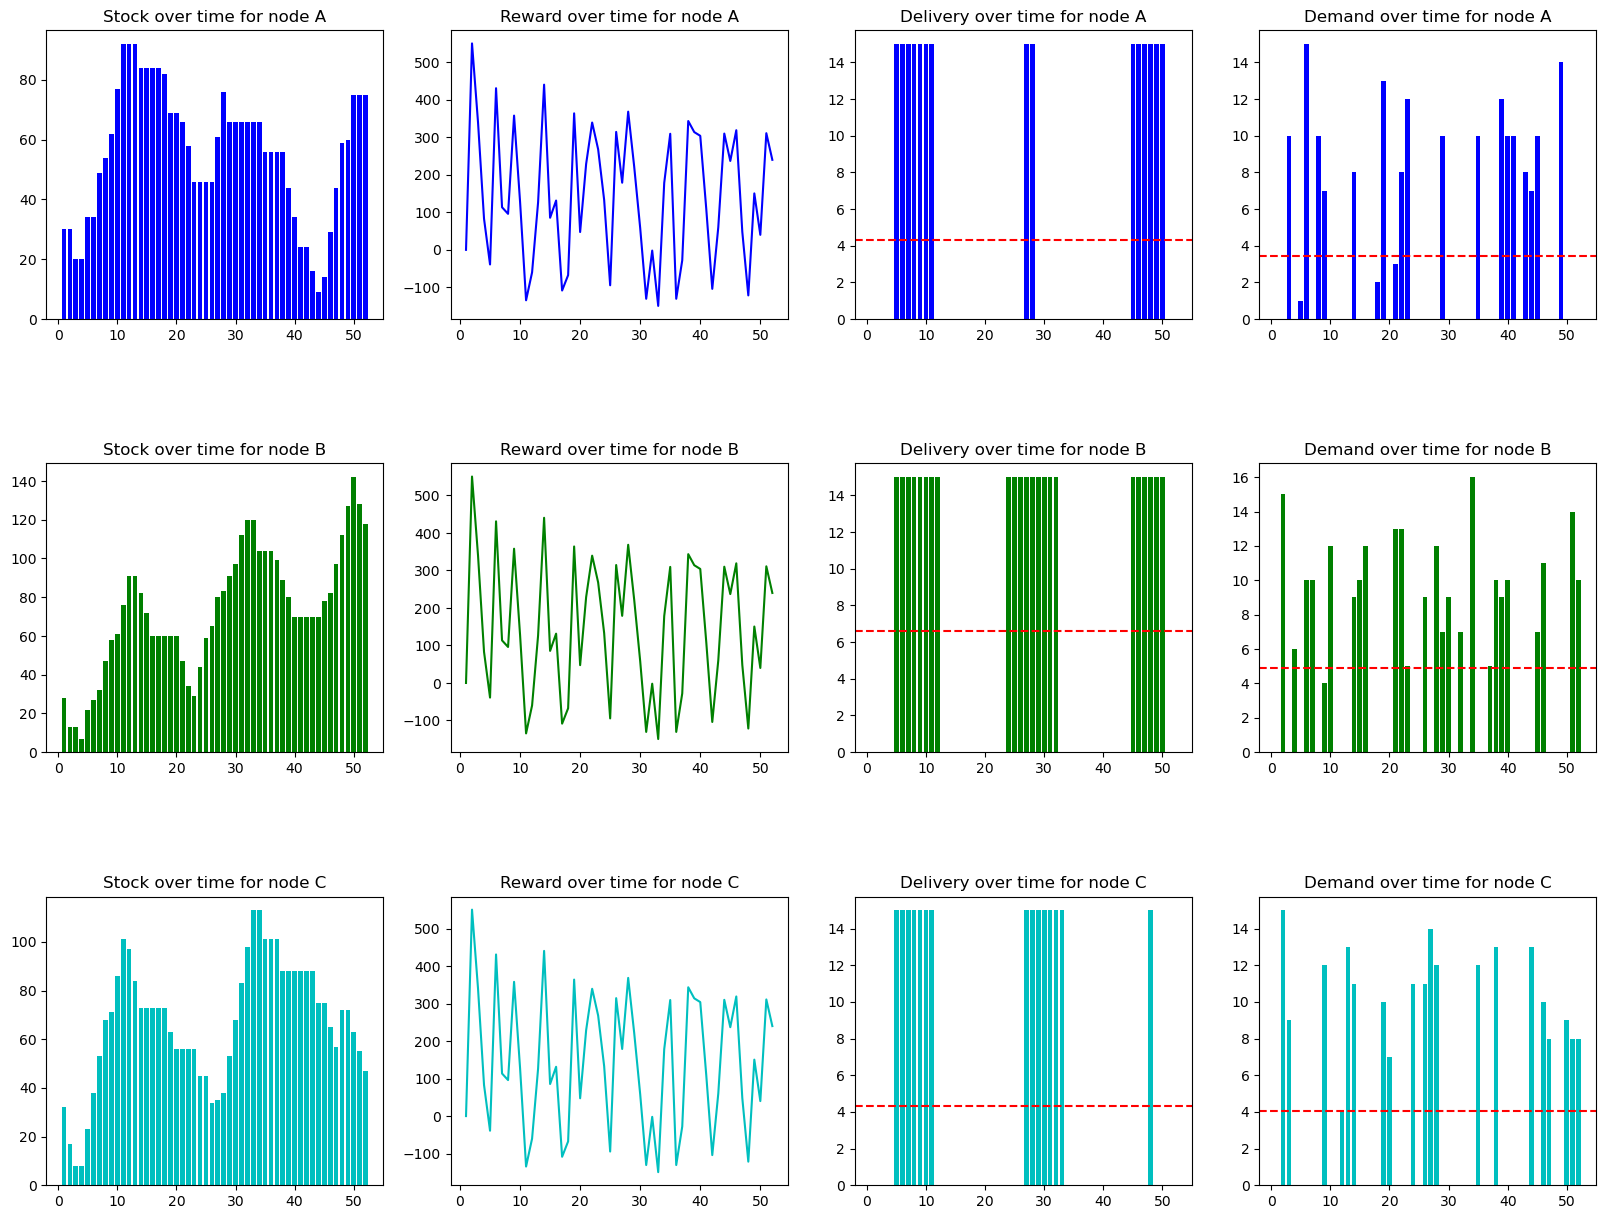

In [17]:
file = './Data/2024-11-04_20_last_environment_data_None.csv'
df = pd.read_csv(file)
plot_data(df)